In [1]:
# ! pip install hyperopt
# ! pip install hyperas
import os
import sys
import time
import random
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from IPython.display import display, clear_output

import hyperas
import hyperopt
from hyperas.distributions import uniform, choice
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperas import optim

os.chdir(os.getcwd())
warnings.filterwarnings('ignore')

# Final Pre-Processing

In [2]:
train_data = pd.read_pickle(r"C:\Users\StanvanLoon\OneDrive - Umbrio B.V\Documents\GitHub\VU_ATM\assignment3\Data\tmtrain.Preprocessed.pickle")
dev_data = pd.read_pickle(r"C:\Users\StanvanLoon\OneDrive - Umbrio B.V\Documents\GitHub\VU_ATM\assignment3\Data\tmdev.Preprocessed.pickle")
train_data = pd.concat([train_data, dev_data]).reset_index(drop=True)
train_data.columns

Index(['Token_ID', 'Token', 'Lemma', 'POS', 'POS_TAG', 'Dependency_Head',
       'Dependency_Label', 'idx_sent', 'Negation_cue', 'Token_vector',
       'next_token', 'next_token_vector', 'prev_token', 'prev_token_vector',
       'trigram', 'trigram_list_tokens', 'trigram_list_vectors', 'prev_bigram',
       'prev_bigram_list_tokens', 'prev_bigram_list_vectors', 'next_bigram',
       'next_bigram_list_tokens', 'next_bigram_list_vectors', 'HECT', 'HECA'],
      dtype='object')

# Feature Ablation Study

In [3]:
def sum_vectors(vectors):
    vectors = deepcopy(vectors)
    result = vectors[0]
    for i in range(1, len(vectors)): result *= vectors[i]
    return result.tolist()
    
def get_vector_features(row, features):
    result = []

    # Add boolean features
    if 'HECT' in features: result.append(row.HECT)
    if 'HECA' in features: result.append(row.HECA)

    # Add vector features
    if 'Token_vector' in features: result.extend(list(row.Token_vector))
    if 'next_token_vector' in features: result.extend(row.next_token_vector)
    if 'prev_token_vector' in features: result.extend(row.prev_token_vector)
    if 'Dependency_Head' in features: result.append(row.Dependency_Head)

    # Add multiple-vector features
    if 'trigram_list_vectors' in features: result.extend(sum_vectors(row.trigram_list_vectors))
    if 'prev_bigram_list_vectors' in features: result.extend(sum_vectors(row.prev_bigram_list_vectors))
    if 'next_bigram_list_vectors' in features: result.extend(sum_vectors(row.next_bigram_list_vectors))

    return result

def get_categorical_features(features, data):
    return pd.get_dummies(data[features]).values

def get_features(features, data):
    X = []
    vec_features = []
    cat_features = []
    all_vec_features = ['Token_vector', 'next_token_vector', 'prev_token_vector', 'trigram_list_vectors', 'prev_bigram_list_vectors', 'next_bigram_list_vectors', 'HECT', 'HECA']
    all_cat_features = ['POS', 'POS_TAG', 'Dependency_Label']
    
    # Classify features
    for feature in features:
        if feature in all_vec_features: vec_features.append(feature)
        if feature in all_cat_features: cat_features.append(feature)
    
    # If both vector and categorical features exist
    if vec_features and cat_features:
        cat_values = get_categorical_features(cat_features, data)
        for i in range(len(data)):
            X.append(np.append(cat_values[i], get_vector_features(data.iloc[i], vec_features)))
    
    # Only vector features
    elif vec_features:
        X = data.apply(get_vector_features, args=(vec_features,), axis=1).tolist()
    
    # Only categorical features
    elif cat_features:
        X = get_categorical_features(cat_features, data)

    return X

In [4]:
def feature_ablation(all_features):
    
    best_scores = []
    order_of_removal = []
    features_to_use = all_features.copy()
    
    while len(features_to_use) > 1:
        
        scores = []
        print('\n', features_to_use)

        for feature in features_to_use:
            
            # Get new feature list
            temp_features = deepcopy(features_to_use)
            temp_features.remove(feature)
            
            # Generate new data
            sample = random.sample(range(len(train_data)), int(len(train_data)*0.5))
            X = get_features(temp_features, deepcopy(train_data.iloc[sample]))
            y = train_data.loc[sample, 'Negation_cue'].values
            
            split = int(len(y)*0.75)
            
            train_x = X[:split]
            train_y = y[:split]
            dev_x = X[split:]
            dev_y = y[split:]
                        
            # Build new classifier
            svm = pipeline.make_pipeline(StandardScaler(), SVC(gamma='auto'))
            svm.fit(train_x, train_y)

            # Measure performance
            prediction = svm.predict(dev_x)
            score = f1_score(dev_y, prediction, average='weighted')
            scores.append(score)
            print(score)

        # Remove worst feature
        index_worst_feature = np.argmax(scores)
        feature_to_delete = features_to_use[index_worst_feature]
        features_to_use.remove(feature_to_delete)
        
        # Save progress
        best_scores.append(np.max(scores))
        order_of_removal.append(feature_to_delete)
    
    return order_of_removal, best_scores

In [5]:
all_features = ['Token_vector', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'next_token_vector',
                'prev_token_vector', 'trigram_list_vectors', 'prev_bigram_list_vectors', 'next_bigram_list_vectors',
                'HECT', 'HECA']

order_of_removal, best_scores = feature_ablation(all_features)


 ['Token_vector', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'next_token_vector', 'prev_token_vector', 'trigram_list_vectors', 'prev_bigram_list_vectors', 'next_bigram_list_vectors', 'HECT', 'HECA']
0.9953167576124043
0.9960648935969968
0.9959021929534879
0.997113466275445
0.9962875720658244
0.9966166167856149
0.9967146201227052
0.9960378807015857
0.9975600054345006
0.9956507130944252
0.996155598938164
0.9956999253422553

 ['Token_vector', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'next_token_vector', 'prev_token_vector', 'trigram_list_vectors', 'next_bigram_list_vectors', 'HECT', 'HECA']
0.9959865189054636
0.9959214602188106
0.9964489476833791
0.9967170411303337
0.9958096526918655
0.9975466073580551
0.9961457704242928
0.9969467445002412
0.9957626244318862
0.9957860963129658
0.9951806156367817

 ['Token_vector', 'POS', 'POS_TAG', 'Dependency_Head', 'Dependency_Label', 'prev_token_vector', 'trigram_list_vectors', 'next_bigram_list_vectors', 'HECT', 'HECA']


In [6]:
order_of_removal.reverse()
order_of_removal.append('Use all features')

best_scores.reverse()
best_scores.append(best_scores[-1])

In [8]:
pd.DataFrame(order_of_removal).to_csv('order_of_removal_SVM.csv', index=False)
pd.DataFrame(best_scores).to_csv('best_scores_SVM.csv', index=False)

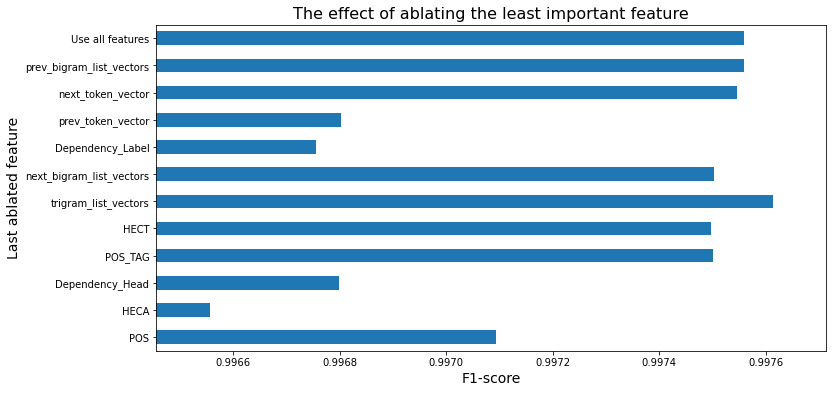

In [41]:
df_bar = pd.DataFrame({'F1-score': best_scores}, columns=['F1-score'], index=order_of_removal)

df_bar.plot.barh(figsize=(12,6),
                 legend=False,
                 xlim=(np.min(best_scores)-0.0001, np.max(best_scores)+0.0001))

plt.title('The effect of ablating the least important feature', size=16)
plt.xlabel('F1-score', size=14)
plt.ylabel('Last ablated feature', size=14)
plt.savefig('FAS_CRF.pdf')
plt.show()

In [9]:
features_to_use = ['HECT', 'HECA', 'POS', 'Dependency_head', 'POS_TAG']
X = get_features(features_to_use, deepcopy(train_data))
y = train_data.Negation_cue.values

split = int(len(X)*0.75)

train_x = X[:split]
dev_x = X[split:]
train_y = y[:split]
dev_y = y[split:]

# HyperOpt

In [13]:
space = {'C': hp.uniform('C', 0.01, 5), # Gives the upper an lower limit
         'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf']), # HyperOpt has to choose one
         'gamma': hp.choice('gamma', ['scale', 'auto'])} # HyperOpt has to choose one

def optimizer(space):
    
    svm = SVC(C=space['C'],
              kernel=space['kernel'],
              gamma=space['gamma'])
    svm = pipeline.make_pipeline(StandardScaler(), svm)
    
    svm.fit(train_x, train_y)
    
    prediction = svm.predict(dev_x)
    F1_score = f1_score(dev_y, prediction, average='weighted')
    
    return {'loss': -F1_score, 'status': STATUS_OK}

SVM_trails = Trials()

SVM_best = fmin(fn=optimizer,
                space=space,
                algo=tpe.suggest,
                max_evals=300, # Set to a 100 or so for the final run when u know everything is working
                trials=SVM_trails)
SVM_best

100%|█████████████████████████████████████████████| 300/300 [17:57<00:00,  3.59s/trial, best loss: -0.9970734592704813]


{'C': 2.6405611285523425, 'gamma': 0, 'kernel': 2}

In [25]:
SVM_best = hyperopt.space_eval(space, SVM_best)
SVM_best

{'C': 2.6405611285523425, 'gamma': 'scale', 'kernel': 'rbf'}

# Results on Dev and Test data

In [26]:
os.chdir(r'C:\Users\StanvanLoon\OneDrive - Umbrio B.V\Documents\Master Business Analytics\Applied Text Mining\3. Corpus preprocessing and feature extraction')

train_data = pd.read_pickle(r"C:\Users\StanvanLoon\OneDrive - Umbrio B.V\Documents\GitHub\VU_ATM\assignment3\Data\tmtrain.Preprocessed.pickle")
dev_data = pd.read_pickle(r"C:\Users\StanvanLoon\OneDrive - Umbrio B.V\Documents\GitHub\VU_ATM\assignment3\Data\tmdev.Preprocessed.pickle")
cardboard_data = pd.read_pickle('Data/SEM-2012-SharedTask-CD-SCO-test-cardboard.Preprocessed.pickle')
circle_data = pd.read_pickle('Data/SEM-2012-SharedTask-CD-SCO-test-circle.Preprocessed.pickle')
all_data = pd.concat([train_data, dev_data, cardboard_data, circle_data]).reset_index(drop=True)

In [32]:
features_to_use = ['HECT', 'HECA', 'POS', 'Dependency_head', 'POS_TAG']

X = get_features(features_to_use, deepcopy(all_data))
y = all_data.Negation_cue.values

In [34]:
train_x = X[:len(train_data)]
train_y = y[:len(train_data)]

dev_x = X[len(train_data):-len(test_data)]
dev_y = y[len(train_data):-len(test_data)]

test_x = X[-len(test_data):]
test_y = y[-len(test_data):]

print(len(train_data), len(train_x), len(train_y))
print(len(dev_data), len(dev_x), len(dev_y))
print(len(cardboard_data) + len(circle_data), len(test_x), len(test_y))

65451 65451 65451
13567 13567 13567
19216 19216 19216


In [36]:
svm = SVC(C=SVM_best['C'],
          kernel=SVM_best['kernel'],
          gamma=SVM_best['gamma'])
svm = pipeline.make_pipeline(StandardScaler(), svm)

svm.fit(train_x, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=2.6405611285523425))])

## Development data

In [37]:
pred_dev = svm.predict(dev_x)
f1_score(dev_y, pred_dev, average='weighted')

0.9967513195836512

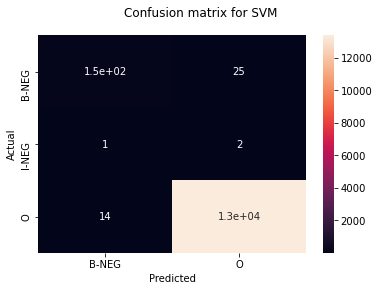

In [38]:
confusion_matrix = pd.crosstab(pd.DataFrame(dev_y)[0], pd.DataFrame(pred_dev)[0], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.suptitle('Confusion matrix for SVM')
plt.savefig('CM_SVM_dev.pdf')
plt.show()

# Test data

In [39]:
pred_test = svm.predict(test_x)
f1_score(test_y, pred_test, average='weighted')

0.9962399179701481

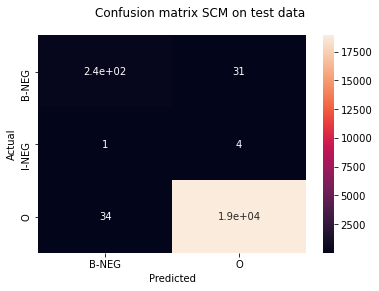

In [40]:
confusion_matrix = pd.crosstab(pd.DataFrame(test_y)[0], pd.DataFrame(pred_test)[0], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.suptitle('Confusion matrix SCM on test data')
plt.savefig('CM_SVM_test.pdf')
plt.show()

# Baseline on the test data

In [52]:
predictions = test_data.HECT + test_data.HECA
for i in range(len(predictions)):
    if predictions[i] > 0:
        predictions[i] = 'B-NEG'
    else:
        predictions[i] = 'O'

actual_values = test_y
f1_score(actual_values, predictions, average='weighted')

0.9956888582069178